#CE888-Final Assignment: Breast Cancer
## Imbalanced Datasets (Supervised)

In [1]:
import os
import pandas as pd
import numpy as np
import sklearn
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import re

from matplotlib import gridspec
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import files
from sklearn.model_selection import train_test_split,KFold, cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.decomposition import PCA, KernelPCA
from sklearn import tree
from sklearn.metrics import (confusion_matrix,recall_score, make_scorer,
                    precision_score,accuracy_score,f1_score,
                    silhouette_score, completeness_score,silhouette_samples)
from sklearn.ensemble import RandomForestClassifier
from sklearn.cluster import KMeans


### 1. Load, prepare, and inspect the datasets.


In [2]:
# Load the data set on Breast cancer detection
df3 = pd.read_csv('Breast_cancer_data.csv')
df3.loc[df3["diagnosis"]==0,"diagnosis"]=2
df3.loc[:,"diagnosis"]-=1
df3.head()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,1
1,20.57,17.77,132.90,1326.0,0.08474,1
2,19.69,21.25,130.00,1203.0,0.10960,1
3,11.42,20.38,77.58,386.1,0.14250,1
4,20.29,14.34,135.10,1297.0,0.10030,1


In [3]:
#Before splitting into test and training set, we explore the size and the class proportions in order to confirm it has the right level of imbalance
print("Shape: ", df3.shape)
#Class proportions
print("Class Proportions:\n", df3["diagnosis"].value_counts()/df3["diagnosis"].shape)

Shape:  (569, 6)
Class Proportions:
 0    0.627417
1    0.372583
Name: diagnosis, dtype: float64


In [4]:
#Split into 90-10
X_3=df3.iloc[:,0:-1].copy()
Y_3=df3.iloc[:,-1].copy()

x_3=X_3.copy()
y_3=Y_3.copy()

features3=X_3.columns
x3_train, x3_test, y3_train, y3_test=train_test_split(x_3,y_3, train_size=0.9, random_state=21, stratify=y_3)

In [5]:
#We check the proportions of the sets to confirm the imbalance is preserved
print("Train Shape: ", x3_train.shape)
#Class proportions
print("Train class Proportions:\n", y3_train.value_counts()/y3_train.shape)

print("Test shape: ", x3_test.shape)
#Class proportions
print("Test class Proportions:\n", y3_test.value_counts()/y3_test.shape)

Train Shape:  (512, 5)
Train class Proportions:
 0    0.626953
1    0.373047
Name: diagnosis, dtype: float64
Test shape:  (57, 5)
Test class Proportions:
 0    0.631579
1    0.368421
Name: diagnosis, dtype: float64


In [6]:
#Print proportion of missing values
proportion=[]
for f in features3:
  proportion.append(x3_train[f].isna().sum(0)/x3_train.shape[0]*100)  
  print(f+": ", "{0:.2f}".format(x3_train[f].isna().sum(0)/df3.shape[0]*100))

print("Traget class: ", "{0:.2f}".format(y3_train.isna().sum(0)/y3_train.shape[0]*100))

mean_radius:  0.00
mean_texture:  0.00
mean_perimeter:  0.00
mean_area:  0.00
mean_smoothness:  0.00
Traget class:  0.00


In [7]:
# Descriptive sattistics in Latex format
x3_train.describe().transpose() #.to_latex(float_format="%.2f"))   #latex for the report.

,count,mean,std,min,25%,50%,75%,max
mean_radius,512.0,14.097230,3.508969,6.98100,11.687500,13.280000,15.715000,27.4200
mean_texture,512.0,19.311680,4.372759,9.71000,16.130000,18.880000,21.847500,39.2800
mean_perimeter,512.0,91.774473,24.230771,43.79000,74.967500,85.980000,103.475000,186.9000
mean_area,512.0,651.669141,348.178372,143.50000,419.525000,545.650000,762.925000,2501.0000
mean_smoothness,512.0,0.096588,0.014282,0.05263,0.086508,0.095955,0.105925,0.1634


In [8]:
##Since the scales and distribution characteristics of the features are too different we decide to normalize them. 
#In this step we create a copy to visualize them in a boxplot.
#However during the cross-validation steps we will use the original training set and normalize it inside the loop. 
scaler=StandardScaler()
x3_train_norm=x3_train.copy()
x3_train_norm[:]=scaler.fit_transform(x3_train_norm[:])
y3_train_norm=y3_train.copy()

#normalize test set using parameters from training set.
x3_test_norm=x3_test.copy()
x3_test_norm[:]=scaler.fit_transform(x3_test_norm[:])
y3_test_norm=y3_test.copy()


Optimal number of features : 4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:103: FutureWarning: The `grid_scores_` attribute is deprecated in version 1.0 in favor of `cv_results_` and will be removed in version 1.2.
  warnings.warn(msg, category=FutureWarning)


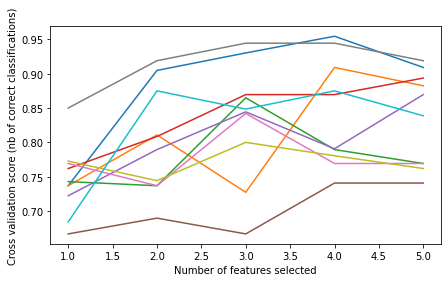

In [9]:
#Recursive Cross-Validated Feature Selection 
#We use the same folds from this point on
k_fold = KFold(n_splits=10) 
feature_selection=tree.DecisionTreeClassifier(criterion = "entropy", random_state=21)
f1_scorer=make_scorer(f1_score)
selector=RFECV(feature_selection,cv=k_fold,scoring=f1_scorer)
selector.fit(x3_train_norm,y3_train)
#keeping selected variables and printing names for control
x_best=x3_train_norm.loc[:,selector.get_support()]
xv_best=x3_test_norm.loc[:,selector.get_support()]
print("Optimal number of features : %d" % selector.n_features_)

# Plot number of features VS. cross-validation scores
fig = plt.subplots(figsize=(7,4))
plt.xlabel("Number of features selected")
plt.ylabel("Cross validation score (nb of correct classifications)")
plt.plot(range(1, len(selector.grid_scores_) + 1), selector.grid_scores_)


Auxiliar functions

In [10]:
#Bootstraping mean
def boostrap_mean(sample, sample_size, n_iterations):
	bootstrap_samples=np.random.choice(sample, size=(n_iterations,sample_size), replace=True)
	mean_array=np.mean(bootstrap_samples, axis=1)
	data_mean=np.mean(mean_array)
	lower=np.percentile(mean_array,2.5)
	upper=np.percentile(mean_array,97.5)
	return data_mean, lower, upper

#Bootstraping standard deviation
def boostrap_std(sample, sample_size, n_iterations):
	bootstrap_samples=np.random.choice(sample, size=(n_iterations,sample_size), replace=True)
	std_array=np.std(bootstrap_samples, axis=1)
	data_std=np.mean(std_array)
	return data_std

#Distance function from the Total within-cluster sum of sqaures to the arch. Used during the Elbow method 
def calc_distance(x1,y1,a,b,c):
  d=abs(a*x1+b*y1+c)/((a*a+b*b)**0.5)
  return d

#permutation test: mean difference	p-value
def permutation_test(array1, array2, n_iterations):
  results=[]
  current_mean=np.mean(array1)
  new_mean=np.mean(array2)
  t_obs=new_mean-current_mean
  concat = np.concatenate((array1, array2))
  for i in range(n_iterations):    
    perm = np.random.permutation(concat)
    pcurrent= perm[:len(array1)]
    pnew= perm[len(array1):]
    t_perm=np.mean(pnew)-np.mean(pcurrent)
    if t_perm>t_obs:
      results.append(1)
    else:
      results.append(0)
  p_value=np.sum(results)/n_iterations
  return(p_value)

## 2.RF Baselines

In [23]:
#Empty lists to store results
accuracy_base=[]
f1_base=[]
g_mean_base=[]
metrics_base={"accuracy": accuracy_base, "f1": f1_base, "g-mean": g_mean_base}

#baselines
rf_base=  RandomForestClassifier(500, random_state=42)
clf=[rf_base]

#10-fold cross validation trhough each baseline
for c in clf:
  c_name=c.__class__.__name__
  print("Classifier: %s" % c_name)
  for train_indices, test_indices in k_fold.split(x3_train):
    #Train-validation split using best features
    x3_train_f=x3_train.iloc[train_indices,selector.get_support()].copy()
    x3_train_f[:]=scaler.fit_transform(x3_train_f[:])
    y3_train_f=y3_train.iloc[train_indices].copy()
    x3_val_f=x3_train.iloc[test_indices,selector.get_support()].copy()
    x3_val_f[:]=scaler.transform(x3_val_f[:])
    y3_val_f=y3_train.iloc[test_indices].copy()
  
    #training baseline
    c.fit(x3_train_f, y3_train_f)
    
    #predicting class and computing metrics
    y_hat=c.predict(x3_val_f)
    f1_f=f1_score(y3_val_f,y_hat)
    acc_f=accuracy_score(y3_val_f,y_hat)
    pr_r=precision_score(y3_val_f,y_hat)
    rec_f=recall_score(y3_val_f,y_hat)
    gmean_f=(pr_r*rec_f)**(0.5)

    #appending to results
    accuracy_base.append([acc_f,c.__class__.__name__])
    f1_base.append([f1_f,c.__class__.__name__])
    g_mean_base.append([gmean_f,c.__class__.__name__])
  
  #printing results for each baseline
  for m, v in metrics_base.items():
    mean,l,u=boostrap_mean(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float), \
                          len(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float)),10000)
    std=boostrap_std(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float), \
                          len(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float)),10000)
    print("%s \nmean: %0.4f, lower: %0.4f, upper: %0.4f, std: %0.4f " % (m,mean, l,u,std))
  print("\n")

Classifier: RandomForestClassifier
accuracy 
mean: 0.9178, lower: 0.8942, upper: 0.9414, std: 0.0356 
f1 
mean: 0.8847, lower: 0.8519, upper: 0.9183, std: 0.0503 
g-mean 
mean: 0.8872, lower: 0.8554, upper: 0.9202, std: 0.0490 




Random upsampling (not included in the report)

In [12]:
#Empty lists to store results
accuracy_up=[]
f1_up=[]
g_mean_up=[]
metrics_up={"accuracy": accuracy_up, "f1": f1_up, "g-mean": g_mean_up}

#upsampling learner
rf_up=  RandomForestClassifier(500, random_state=21)

#10-fold CV for the random upsampling
for train_indices, test_indices in k_fold.split(x3_train):
  #Train-validation split using best features
    x3_train_f=x3_train.iloc[train_indices,selector.get_support()].copy()
    x3_train_f[:]=scaler.fit_transform(x3_train_f[:])
    y3_train_f=y3_train.iloc[train_indices].copy()
    x3_val_f=x3_train.iloc[test_indices,selector.get_support()].copy()
    x3_val_f[:]=scaler.transform(x3_val_f[:])
    y3_val_f=y3_train.iloc[test_indices].copy()
    
    #Randome Upsampling is conducted
    idx=np.random.choice(x3_train_f.index[y3_train_f==1], size=(x3_train_f[y3_train_f==0].shape[0]), replace=True)
    upx=x3_train_f.loc[idx]
    upy=y3_train_f.loc[idx]
    x3_train_f=x3_train_f[y3_train_f==0].append(upx)
    y3_train_f=y3_train_f[y3_train_f==0].append(upy)
    
    #training classifier with upsampled training set
    rf_up.fit(x3_train_f, y3_train_f)

    #prediction and metrics estimation
    y_hat=rf_up.predict(x3_val_f)
    f1_f=f1_score(y3_val_f,y_hat)
    acc_f=accuracy_score(y3_val_f,y_hat)
    pr_r=precision_score(y3_val_f,y_hat)
    rec_f=recall_score(y3_val_f,y_hat)
    gmean_f=(pr_r*rec_f)**(0.5) 

    #appending results to  list
    accuracy_up.append([acc_f,c.__class__.__name__])
    f1_up.append([f1_f,c.__class__.__name__])
    g_mean_up.append([gmean_f,c.__class__.__name__])

#prinitng upsampling results
for m, v in metrics_up.items():
  mean,l,u=boostrap_mean(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float), \
                        len(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float)),10000)
  std=boostrap_std(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float), \
                        len(np.array(v)[np.array(v)[:,1]==c_name][:,0].astype(float)),10000)
  print("%s \nmean: %0.4f, lower: %0.4f, upper: %0.4f, std: %0.4f " % (m,mean, l,u,std))
print("\n")

accuracy 
mean: 0.9119, lower: 0.8824, upper: 0.9395, std: 0.0442 
f1 
mean: 0.8797, lower: 0.8403, upper: 0.9172, std: 0.0579 
g-mean 
mean: 0.8822, lower: 0.8445, upper: 0.9186, std: 0.0560 




## 3. Cluster Analysys

In [15]:
#defining maximum number of clusters
kmax=10 
#creating empty lists to store results
accuracy_cluster=[]
f1_cluster=[]
g_mean_cluster=[]
metrics_cluster={"accuracy": accuracy_cluster, "f1": f1_cluster, "g-mean": g_mean_cluster}

#10-fold CV for cluster-based method
i=1 #iterator variable
for train_indices, test_indices in k_fold.split(x3_train):
  print("Fold: %s" % i) #control message
  #Training-validation split
  x3_train_f=x3_train.iloc[train_indices,selector.get_support()].copy()
  x3_train_f[:]=scaler.fit_transform(x3_train_f[:])
  y3_train_f=y3_train.iloc[train_indices].copy()
  x3_val_f=x3_train.iloc[test_indices,selector.get_support()].copy()
  x3_val_f[:]=scaler.transform(x3_val_f[:])
  y3_val_f=y3_train.iloc[test_indices].copy()

  #####################################
  #Optimal number of clusters selection
  #####################################
  k_optimal=[]  #empty list to store results from each method
  wss=[]  #empty list for sum of squares
  silhouette_avg=[] #empty list for silhouette score

  #compute 'kmax' different clusters
  for k in range(1,kmax+1):
    kmeans = KMeans(n_clusters=k, random_state=21)  #defining algorithm
    cluster=kmeans.fit_predict(x3_train_f)  #fit kmeans
    #append silhouette score >1 as for k=1 it is not defined
    if k!=1:
      sil=silhouette_score(x3_train_f, cluster)
      silhouette_avg.append(sil)
    #append sum of squares
    wss.append(kmeans.inertia_)

  ################
  #Elbow Method
  ################
  #Rescale sum of squares
  # wss=(wss-min(wss))/(max(wss)-min(wss))

  #defining variables to compute distance from sum of squares curve
  #to the arch connecting both extremes (see plot below)
  a=wss[0]-wss[-1]
  b=list(range(1,kmax+1))[-1]-list(range(1,kmax+1))[0]
  c1=list(range(1,kmax+1))[0]*wss[-1]
  c2=list(range(1,kmax+1))[-1]*wss[0]
  c=c1-c2

  #computing distance from sum of squares curve to the arch
  distance=[]
  for k in range(kmax):
    distance.append(calc_distance(list(range(1,kmax+1))[k],wss[k],a,b,c))
  #appending optimal K based on the elbow method
  k_optimal.append(list(range(1,kmax+1))[np.argmax(distance)])

  ###################
  #Silhouette Method 
  ################## 
  #appending optimal K as that with the maximum silhouette score
  k_optimal.append(list(range(2,kmax+1))[np.argmax(silhouette_avg)])

  #choosing the max between the two methods (as it yields better results
  #than selecting the min)
  k_optimal=max(k_optimal)
  print("Best k: %s" % k_optimal) #print optimal K

  ################
  #Learning stage
  ################
  #defining kmeans algorithm
  kmeans = KMeans(n_clusters=k_optimal, random_state=21)
  cluster=kmeans.fit_predict(x3_train_f)  #fitting kmeans algorithm

  #checking whether all clusters have instances from the same class
  i2=0  #iterator
  rf={} #empty dictionary to store Random Forest classifieres
  #iterating through the clusters
  for k in range(k_optimal):
    #checking if cluster is 'complete' (instances from same class)
    if (y3_train_f[cluster==k].unique().shape[0]==1) is False:
      #defining classifier and storing it in the dictionary
      rf['rf_{0}'.format(k)] = RandomForestClassifier(500, random_state=21)
      #training classifier
      rf[list(rf.keys())[i2]].fit(x3_train_f[cluster==k],y3_train_f[cluster==k])
      i2+=1 #increasing iterator

  ##################
  #predicting Stage
  ##################
  #fitting kmeans on validation set previoulsy trained using training set
  y_hat=kmeans.predict(x3_val_f)  
  i3=0 #iterator
  #Loop through clusters to check if it has instances from the same class
  for k in range(k_optimal):
    #checking if cluster is 'complete'
    if (y3_train_f[cluster==k].unique().shape[0]==1) is True:
      #if it is complete, assign the corresponding class to the validation instances in that cluster
      y_hat[y_hat==k]=np.mean(y3_train_f[cluster==k])
    else:
      #if not use the pre-trained classifier to predict the class
      y_hat[y_hat==k]=rf[list(rf.keys())[i3]].predict(x3_val_f[y_hat==k])
      i3+=1 #increase iterator

  #computing metrics
  f1_f=f1_score(y3_val_f,y_hat)
  acc_f=accuracy_score(y3_val_f,y_hat)
  pr_r=precision_score(y3_val_f,y_hat)
  rec_f=recall_score(y3_val_f,y_hat)
  gmean_f=(pr_r*rec_f)**(0.5)

  #appending metrics to lists
  accuracy_cluster.append([acc_f,i])
  f1_cluster.append([f1_f,i])
  g_mean_cluster.append([gmean_f,i])
  i+=1 

print("\n") 
#printing results
for m, v in metrics_cluster.items():
  mean,l,u=boostrap_mean(np.array(v)[:,0].astype(float), \
                        len(np.array(v)[:,0].astype(float)),10000)
  std=boostrap_std(np.array(v)[:,0].astype(float), \
                        len(np.array(v)[:,0].astype(float)),10000)
  print("%s \nmean: %0.4f, lower: %0.4f, upper: %0.4f, std: %0.4f " % (m,mean, l,u,std))


Fold: 1
Best k: 3
Fold: 2
Best k: 3
Fold: 3
Best k: 3
Fold: 4
Best k: 4
Fold: 5
Best k: 3
Fold: 6
Best k: 3
Fold: 7
Best k: 3
Fold: 8
Best k: 4
Fold: 9
Best k: 3
Fold: 10
Best k: 4


accuracy 
mean: 0.9158, lower: 0.8962, upper: 0.9357, std: 0.0294 
f1 
mean: 0.8765, lower: 0.8449, upper: 0.9098, std: 0.0487 
g-mean 
mean: 0.8795, lower: 0.8483, upper: 0.9109, std: 0.0469 


## 4. Permutation Test

### A) F1 Score

In [22]:
base=["RandomForestClassifier"] #lists with baselines

#compare our method against baselines
for b in base:
  print("F1 Score Mean Difference: Cluster-RF vs %s:" % b)  #message
  cluster=np.array(f1_cluster)[:,0] #getting results from our method
  base=np.array(f1_base)[np.array(f1_base)[:,1]==b][:,0].astype(float) #baselines results
  diff=np.mean(cluster)-np.mean(base) #computing mean difference
  p_value=permutation_test(base,cluster,1000) #estimating p-value
  print("Difference: %0.4f, p-value: %0.4f" % (diff, p_value))  #printing p-value


F1 Score Mean Difference: Cluster-RF vs RandomForestClassifier:
Difference: -0.0037, p-value: 0.5440


### B) G-mean 

In [25]:
base=["RandomForestClassifier"]  #lists with baselines

#compare our method against baselines
for b in base:
  print("G-mean Score Mean Difference: Cluster-RF vs %s:" % b)  #message
  cluster=np.array(g_mean_cluster)[:,0] #getting results from our method
  base=np.array(g_mean_base)[np.array(g_mean_base)[:,1]==b][:,0].astype(float)  #baselines results
  diff=np.mean(cluster)-np.mean(base) #computing mean difference
  p_value=permutation_test(base,cluster,1000) #estimating p-value
  print("Difference: %0.4f, p-value: %0.4f" % (diff, p_value))  #printing p-value

G-mean Score Mean Difference: Cluster-RF vs RandomForestClassifier:
Difference: -0.0076, p-value: 0.6230


### C) Accuracy

In [26]:
base=["RandomForestClassifier"]  #lists with baselines

#compare our method against baselines
for b in base:
  print("Accuracy Mean Difference: Cluster-RF vs %s:" % b)  #message
  cluster=np.array(accuracy_cluster)[:,0]  #getting results from our method
  base=np.array(accuracy_base)[np.array(accuracy_base)[:,1]==b][:,0].astype(float)  #baselines results
  diff=np.mean(cluster)-np.mean(base) #computing mean difference
  p_value=permutation_test(base,cluster,1000) #estimating p-value
  print("Difference: %0.4f, p-value: %0.4f" % (diff, p_value))  #printing p-value

Accuracy Mean Difference: Cluster-RF vs RandomForestClassifier:
Difference: -0.0020, p-value: 0.5610


In [27]:
#converting results to data frames to plot them

m_t=pd.DataFrame([])  #empty data frame
#iterating through cluster-based method results
for m, v in metrics_cluster.items():
  if m!="accuracy":
    m_i=pd.DataFrame(v) #converting results to dataframe
    m_i["metric"]=m #adding results
    m_i.iloc[:,1]="cluster" #indicator column
    m_t=pd.concat([m_t,m_i], ignore_index=True) #appending to empy dataframe

#iterating through baseline results
for m, v in metrics_base.items():
  if m!="accuracy":
    m_i=pd.DataFrame(v) #converting results to dataframe
    m_i["metric"]=m  #adding results
    m_t=pd.concat([m_t,m_i], ignore_index=True) #appending to empy dataframe
 

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


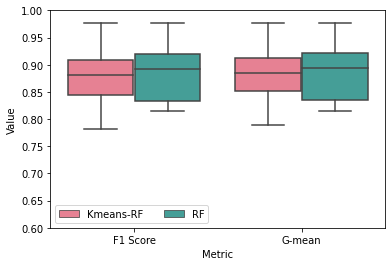

In [29]:
#Plotting results
plot=sns.boxplot(m_t.iloc[:,2],m_t.iloc[:,0],  hue=m_t.iloc[:,1],
                 data=m_t, palette="husl")
handles, _ = plot.get_legend_handles_labels()

plt.legend( title="", fontsize='small', fancybox=True)
plot.legend(handles, ["Kmeans-RF", "RF"],ncol=3)
plot.set(xlabel='Metric', ylabel='Value') #labeling axis
plot.set_ylim((.6,1))
plot.set_xticks(range(m_t.iloc[:,2].unique().shape[0])) 
plot.set_xticklabels(["F1 Score", "G-mean"])
plt.savefig("cancer_box.png", bbox_inches='tight') #saving figure


### 5. Test Set Results

In [30]:
#####################################
#Optimal number of clusters selection
#####################################
k_optimal=[]  #empty list to store results from each method
wss=[]  #empty list for sum of squares
silhouette_avg=[] #empty list for silhouette score
#Iterating thorugh the maximum number of clusters to be tested
for k in range(1,kmax+1):
  kmeans = KMeans(n_clusters=k, random_state=21)
  cluster=kmeans.fit_predict(x_best)
  if k!=1:
      sil=silhouette_score(x_best, cluster)
      silhouette_avg.append(sil)
  wss.append(kmeans.inertia_)

#Elbow Method
#Rescale sum of squares
# wss=(wss-min(wss))/(max(wss)-min(wss))

#defining variables to compute distance from sum of squares curve
#to the arch connecting both extremes (see plot below)
a=wss[0]-wss[-1]
b=list(range(1,kmax+1))[-1]-list(range(1,kmax+1))[0]
c1=list(range(1,kmax+1))[0]*wss[-1]
c2=list(range(1,kmax+1))[-1]*wss[0]
c=c1-c2

#computing distance from sum of squares curve to the arch
distance=[]
for k in range(kmax):
  distance.append(calc_distance(list(range(1,kmax+1))[k],wss[k],a,b,c))

#appending optimal K based on the elbow method
k_optimal.append(list(range(1,kmax+1))[np.argmax(distance)])

###################
#Silhouette Method 
################## 
#appending optimal K as that with the maximum silhouette score
k_optimal.append(list(range(2,kmax+1))[np.argmax(silhouette_avg)])

#choosing the max between the two methods (as it yields better results
#than selecting the min)
k_optimal=max(k_optimal)
print("Best k: %s" % k_optimal) #print optimal K

################
#Learning stage
################
#defining kmeans algorithm
kmeans = KMeans(n_clusters=k_optimal, random_state=21)
cluster=kmeans.fit_predict(x_best)

#checking whether all clusters have instances from the same class
i2=0  #iterator
rf={} #empty dictionary to store Random Forest classifieres
#iterating through the clusters
for k in range(k_optimal):
  #checking if cluster is 'complete' (instances from same class)
  if (y3_train[cluster==k].unique().shape[0]==1) is False:
    #defining classifier and storing it in the dictionary
    rf['rf_{0}'.format(k)] = RandomForestClassifier(500, random_state=21)
    #training classifier
    rf[list(rf.keys())[i2]].fit(x_best[cluster==k],y3_train[cluster==k])
    i2+=1

##################
#predicting Stage
##################
#fitting kmeans on validation set previoulsy trained using training set
y_hat=kmeans.predict(xv_best)
i3=0 #iterator
#Loop through clusters to check if it has instances from the same class
for k in range(k_optimal):
  #checking if cluster is 'complete'
  if (y3_train[cluster==k].unique().shape[0]==1) is True:
    #if it is complete, assign the corresponding class to the validation instances in that cluster
    y_hat[y_hat==k]=np.mean(y3_train[cluster==k])
  else:
    #if not use the pre-trained classifier to predict the class
    y_hat[y_hat==k]=rf[list(rf.keys())[i3]].predict(xv_best[y_hat==k])
    i3+=1

#computing metrics
f1_t=f1_score(y3_test,y_hat)
acc_t=accuracy_score(y3_test,y_hat)
pr_t=precision_score(y3_test,y_hat)
rec_t=recall_score(y3_test,y_hat)
gmean_t=(pr_t*rec_t)**(0.5)

#pritning results
metrics_test={"accuracy": acc_t, "f1": f1_t, "g-mean": gmean_t}
for m, v in metrics_test.items():
  print("Test %s: %0.4f" % (m,v))



Best k: 3
Test accuracy: 0.9825
Test f1: 0.9767
Test g-mean: 0.9770
